# Explore Data In Redshift

In [1]:
!pip install -q SQLAlchemy==1.3.13

In [2]:
import pandas as pd

# Settings
redshift_schema = 'redshift'
redshift_cluster_identifier = 'dsoaws'
redshift_host = 'dsoaws'
redshift_database = 'dsoaws'
redshift_port = '5439'
redshift_table_name = 'amazon_reviews_tsv_2015'

## Load the Redshift Secrets from Secrets Manager

In [3]:
import json
import boto3

secretsmanager = boto3.client('secretsmanager')

secret = secretsmanager.get_secret_value(SecretId='dsoaws_redshift_login')
cred = json.loads(secret['SecretString'])

redshift_username = cred[0]['username']
redshift_pw = cred[1]['password']

In [4]:
redshift = boto3.client('redshift')

response = redshift.describe_clusters(ClusterIdentifier=redshift_cluster_identifier)

redshift_endpoint_address = response['Clusters'][0]['Endpoint']['Address']

print(redshift_endpoint_address)

dsoaws.cy2wlmslzxks.us-west-2.redshift.amazonaws.com


## Create the Redshift Query Engine 

In [5]:
from sqlalchemy import create_engine

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(redshift_username, redshift_pw, redshift_endpoint_address, redshift_port, redshift_database))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


### Using APPROXIMATE COUNT for 'blazing fast' results

The COUNT function counts the rows defined by the expression.

The COUNT function has three variations. COUNT ( * ) counts all the rows in the target table whether they include nulls or not. COUNT ( expression ) computes the number of rows with non-NULL values in a specific column or expression. COUNT ( DISTINCT expression ) computes the number of distinct non-NULL values in a column or expression.

When used with APPROXIMATE, a COUNT ( DISTINCT expression ) function uses a HyperLogLog algorithm to approximate the number of distinct non-NULL values in a column or expression. Queries that use the APPROXIMATE keyword execute much faster, with a low relative error of around 2%. Approximation is warranted for queries that return a large number of distinct values, in the millions or more per query, or per group, if there is a group by clause. For smaller sets of distinct values, in the thousands, approximation might be slower than a precise count. APPROXIMATE can only be used with COUNT ( DISTINCT ).

#### Compare the query execution times of the two queries below. 

In [6]:
%%time
df = pd.read_sql_query("""SELECT approximate count(distinct customer_id)
                                FROM {}.{}
                                GROUP BY product_category""".format(redshift_schema, redshift_table_name), engine)

CPU times: user 5.9 ms, sys: 252 µs, total: 6.15 ms
Wall time: 218 ms


In [7]:
%%time
df = pd.read_sql_query("""SELECT count(distinct customer_id)
                                FROM {}.{}
                                GROUP BY product_category""".format(redshift_schema, redshift_table_name), engine)

CPU times: user 0 ns, sys: 1.88 ms, total: 1.88 ms
Wall time: 142 ms


### Let's do some Visualizations

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


In [9]:
df = pd.read_sql_query("""SELECT product_category,
                COUNT(star_rating) AS count_star_rating
                FROM {}.{}
                GROUP BY product_category
                ORDER BY count_star_rating DESC""".format(redshift_schema, redshift_table_name), engine)

In [10]:
df.head()

,product_category,count_star_rating
0,Digital_Software,35585
1,Digital_Video_Games,30026


In [11]:
# Store number of categories
num_categories = df.shape[0]
print(num_categories)

2


In [12]:
# Store max ratings
max_ratings = df['count_star_rating'].max()
print(max_ratings)

35585


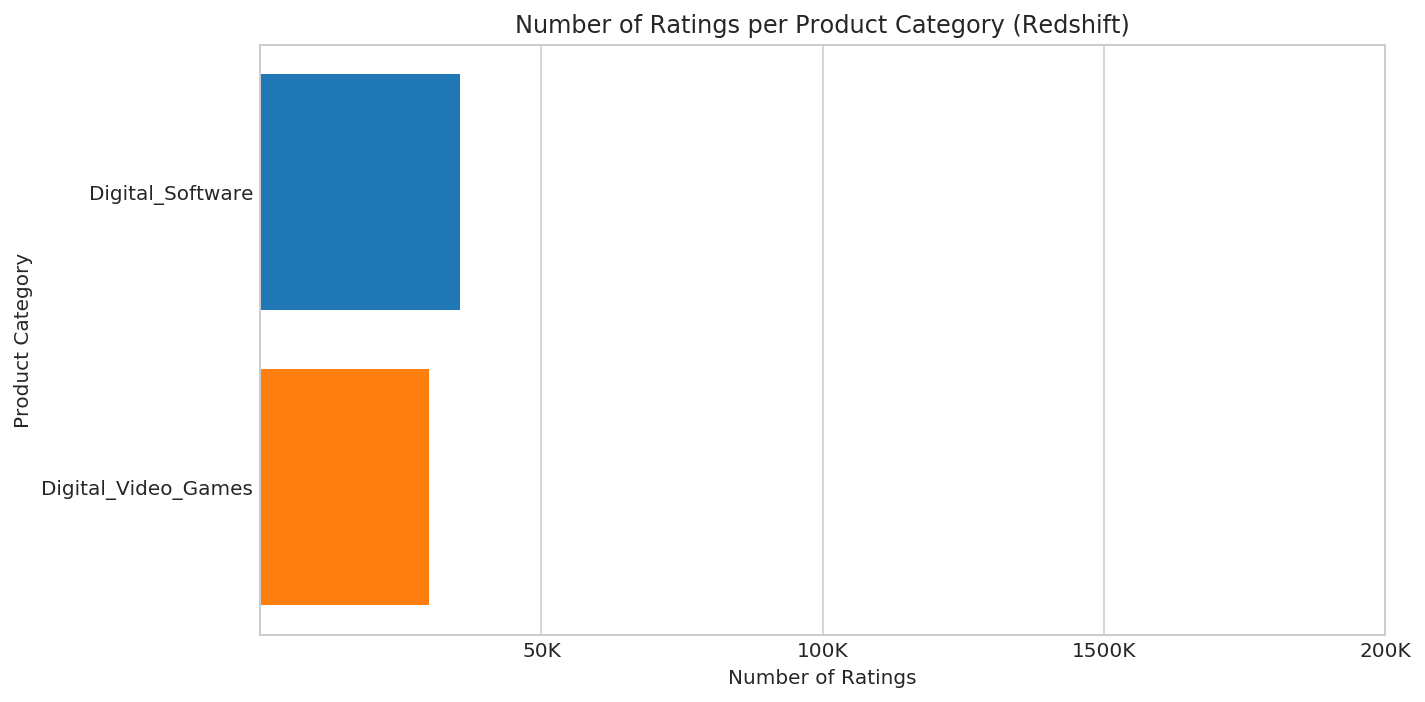

In [13]:
# Set size and style to use
if num_categories > 10:
    plt.figure(figsize=(10,10))
else: 
    plt.figure(figsize=(10,5))
    
plt.style.use('seaborn-whitegrid')

# Create Seaborn barplot
barplot = sns.barplot(y='product_category', x='count_star_rating', data = df, saturation=1)

# Set title
plt.title("Number of Ratings per Product Category (Redshift)")

# Set x-axis ticks to match scale from 10mio reviews to 20mio reviews
if max_ratings <= 8000:
    plt.xticks([10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000], ['10K', '20K', '30K', '40K', '50K', '60K','70K', '80K' ])
    plt.xlim(0, 80000)
elif max_ratings <= 200000:
    plt.xticks([50000, 100000, 150000, 200000], ['50K', '100K', '1500K', '200K'])
    plt.xlim(0, 200000)   
elif max_ratings > 200000:
    plt.xticks([100000, 1000000, 5000000, 10000000, 15000000, 20000000], ['100K', '1m', '5m', '10m','15m','20m'])
    plt.xlim(0, 20000000)

plt.xlabel("Number of Ratings")
plt.ylabel("Product Category")

plt.tight_layout()

# Export plot if needed
# plt.savefig('ratings_per_category.png', dpi=300)

# Show the barplot
plt.show(barplot)

## Query Athena using Redshift Spectrum

In [14]:
athena_schema = 'athena'
athena_table_name = 'amazon_reviews_tsv'


In [15]:
statement = """
SELECT product_category, COUNT(star_rating) AS count_star_rating
FROM {}.{}
GROUP BY product_category
ORDER BY count_star_rating DESC
""".format(athena_schema, athena_table_name)

print(statement)


SELECT product_category, COUNT(star_rating) AS count_star_rating
FROM athena.amazon_reviews_tsv
GROUP BY product_category
ORDER BY count_star_rating DESC



In [16]:
df = pd.read_sql_query(statement, engine)
df.head(5)

,product_category,count_star_rating
0,Digital_Video_Games,145431
1,Digital_Software,102084


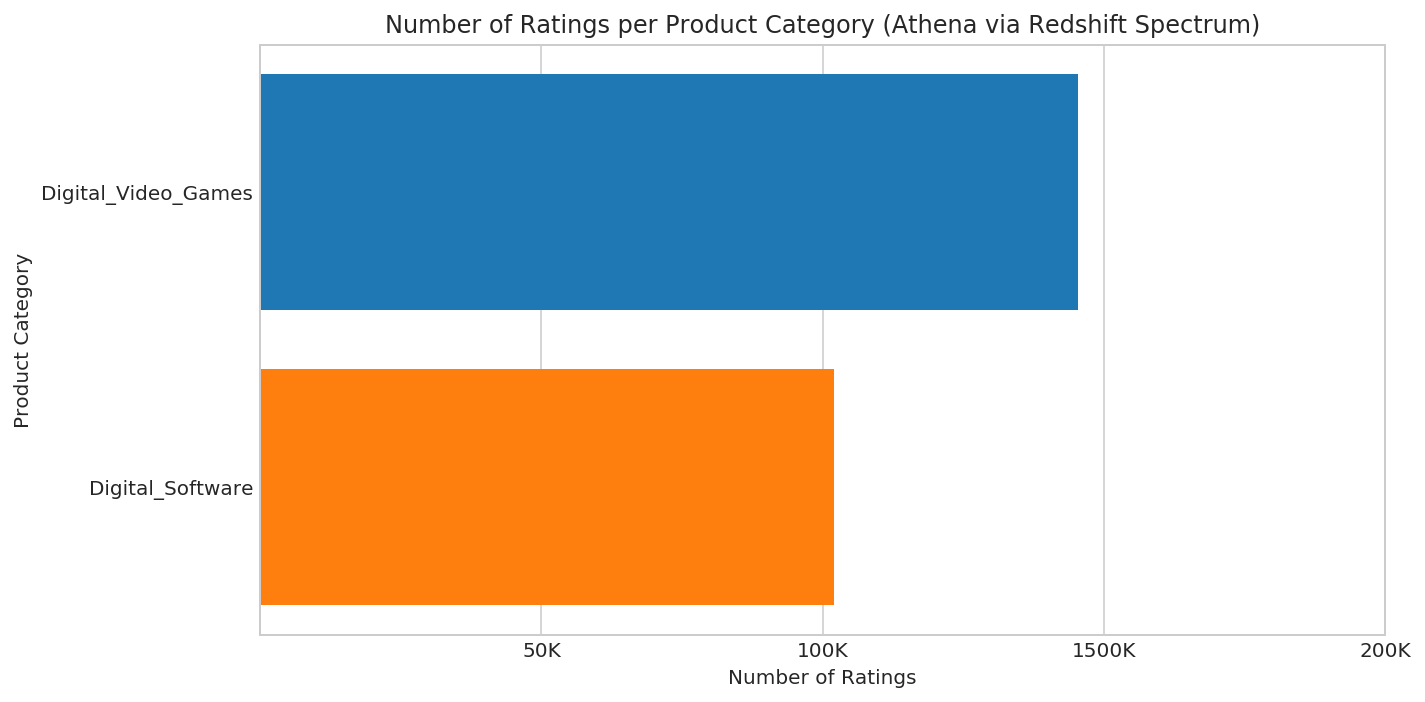

In [17]:
# Set size and style to use
if num_categories > 10:
    plt.figure(figsize=(10,10))
else: 
    plt.figure(figsize=(10,5))

plt.style.use('seaborn-whitegrid')

# Create Seaborn barplot
barplot = sns.barplot(y='product_category', x='count_star_rating', data = df, saturation=1)

# Set title
plt.title("Number of Ratings per Product Category (Athena via Redshift Spectrum)")

# Set x-axis ticks to match scale from 10mio reviews to 20mio reviews
# Set x-axis ticks to match scale from 10mio reviews to 20mio reviews
if max_ratings <= 8000:
    plt.xticks([10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000], ['10K', '20K', '30K', '40K', '50K', '60K','70K', '80K' ])
    plt.xlim(0, 80000)
elif max_ratings <= 200000:
    plt.xticks([50000, 100000, 150000, 200000], ['50K', '100K', '1500K', '200K'])
    plt.xlim(0, 200000)   
elif max_ratings > 200000:
    plt.xticks([100000, 1000000, 5000000, 10000000, 15000000, 20000000], ['100K', '1m', '5m', '10m','15m','20m'])
    plt.xlim(0, 20000000)

plt.xlabel("Number of Ratings")
plt.ylabel("Product Category")

plt.tight_layout()

# Export plot if needed
# plt.savefig('ratings_per_category.png', dpi=300)

# Show the barplot
plt.show(barplot)